**Import required modules**

In [1]:
import random
import functools
import simpy
import numpy as np
import matplotlib.pyplot as plt
import nbconvert
from SimComponents import PacketGenerator, PacketSink, SwitchPort, RandomBrancher, PortMonitor

**Parameters settings**

- mean packet size = 100 bytes
- mean arrival rate = LAMBDA = 4 packets/second
- mean service rate of switch port 1 = MU_1 = 10 packets/second
- mean service rate of switch port 2 = MU_2 = 8 packets/second
- mean service rate of switch port 3 = MU_3 = 9 packets/second

In [2]:
    mean_pkt_size = 100.0  # in bytes
    mean_arrival_rate = 4.0
    mean_service_rate1 = 10.0
    mean_service_rate2 = 8.0
    mean_service_rate3 = 9.0

### Discrete-Event Simulation model

**The definition of simulation components**

***1. Packet***

    A very simple class that represents a packet. This packet will run through a queue at a switch output port. We use the exponential distribution to represent the size of the packet in bytes so that the service rate at the switch port can be identified as Possion process
    
Parameters

- time (float):
    the time the packet arrives at the output queue.
- size  (float):
    the size of the packet in bytes
- id (int):
    an identifier for the packet
- src, dst (int):
    identifiers for source and destination
    
***2. Packet Generator***

    Generates packets with given inter-arrival time distribution. Inter-arrival time is exponential distributed with rate of mean_arrival_rate

Parameters

- env (simpy.Environment):
    the simulation environment
- adist (function):
    a no parameter function that returns the successive inter-arrival times of the packets. This simulation uses exponential distribution, hence the queueing network is considered as Poisson process.
- sdist (function):
    a no parameter function that returns the successive sizes of the packets. The packet size distribution is an exponential distribution. The mean packet size in this simulation is 100 bytes

***3. Packet Sink***

    Receives packets and collects delay information into the waits list. 
    
Parameters
- env (simpy.Environment):
    the simulation environment
- debug (boolean):
    if true then the contents of each packet will be printed as it is received.
- rec_arrivals (boolean):
    if true then arrivals will be recorded
- selector (boolean function): 
    used for selective statistics. Default none.


***4. Switch Port***

    Models a switch output port with a given rate (in bits per second) and buffer size limit in bytes.
    
Parameters

- env (simpy.Environment):
    the simulation environment
- rate (float):
    the bit rate of the port

***5. Random Brancher***

    A demultiplexing element that chooses the output port at random. Contains a list of output ports of the same length as the probability list in the constructor.  Use these to connect to other network elements.

Parameters

- env (simpy.Environment):
    the simulation environment
- probs (List):
    list of probabilities for the corresponding output ports
            
***6. Port Monitor***

    A monitor for an SwitchPort. Looks at the number of items in the SwitchPort in service + in the queue and records that info in the sizes[] list. The monitor looks at the port at time intervals given by the distribution dist.
    
Parameters

- env (simpy.Environment):
    the simulation environment
- port (SwitchPort):
    the switch port object to be monitored.
- dist (function):
    a no parameter function that returns the successive inter-arrival times of the packets

In [3]:
def simulation_run():
    # adist == arrival distribution == arrival_time = 1/mean_arrival_rate
    adist = functools.partial(random.expovariate, mean_arrival_rate)

    # sdist == size distribution
    sdist = functools.partial(random.expovariate, 1/mean_pkt_size)
    samp_dist = functools.partial(random.expovariate, 1.0)

    # port_rate = const 
    #--> service_time = pkt_size*8/port_rate 
    # pkt_size is exponential --> service_time is exponential
                                 
    port_rate1 = mean_service_rate1*(8*mean_pkt_size)  # want a rate of 3 packets per second
    port_rate2 = mean_service_rate2*(8*mean_pkt_size)
    port_rate3 = mean_service_rate3*(8*mean_pkt_size)
    
    # Create the SimPy environment. This is the thing that runs the simulation.
    env = simpy.Environment()

    # Create the packet generators and sink
    def selector(pkt):
        return pkt.src == "PE211"
    
    ps = PacketSink(env, debug=False, rec_arrivals=True, selector=selector)
    
    pg = PacketGenerator(env, "PE211", adist, sdist)

    branch1 = RandomBrancher(env, [0.50, 0.50])
    branch2 = RandomBrancher(env, [1.00, 0.00])
    branch3 = RandomBrancher(env, [0.50, 0.50])

    switch_port1 = SwitchPort(env, port_rate1)
    switch_port2 = SwitchPort(env, port_rate2)
    switch_port3 = SwitchPort(env, port_rate3)

    ###
    ### -->service_time1 =  8*packet_size/port_rate1 = 8*packet_size/(mu_1*8*packet_size) = 1/mu_1
    ###
    
    pm1 = PortMonitor(env, switch_port1, samp_dist)
    pm2 = PortMonitor(env, switch_port2, samp_dist)
    pm3 = PortMonitor(env, switch_port3, samp_dist)

    # Wire packet generators, switch ports, and sinks together
    pg.out = switch_port1
    switch_port1.out = branch1
    branch1.outs[0] = switch_port2
    branch1.outs[1] = switch_port3
    switch_port2.out = branch2
    branch2.outs[0] = switch_port3
    switch_port3.out = branch3
    branch3.outs[0] = switch_port2
    branch3.outs[1] = ps

    # Run it
    env.run(until=8000)
  
    
    print("Last 10 queue sizes in port 1: {}".format(pm1.sizes[-10:]))
    print("lambda_1: {}, dropped {}, lambda {}".format(switch_port1.packets_rec, switch_port1.packets_drop, pg.packets_sent))
    print("loss rate: {}".format(float(switch_port1.packets_drop)/switch_port1.packets_rec))
    
    print("Last 10 queue sizes in port 2: {}".format(pm2.sizes[-10:]))
    print("lambda_2: {}, dropped {}, lambda {}".format(switch_port2.packets_rec, switch_port2.packets_drop, pg.packets_sent))
    print("loss rate: {}".format(float(switch_port2.packets_drop)/switch_port2.packets_rec))
    
    print("Last 10 queue sizes in port 3: {}".format(pm3.sizes[-10:]))
    print("lambda_3: {}, dropped {}, lambda {}".format(switch_port3.packets_rec, switch_port3.packets_drop, pg.packets_sent))
    print("loss rate: {}".format(float(switch_port3.packets_drop)/switch_port3.packets_rec))

    return [ps, pm1, pm2, pm3]

**Store data in the matrix**

Depend on the number of simulation replications, each set of data is stored in the matrix and represented in the plot below. The matrix is then reseted to acquire the latest data.

In [4]:
def deleteInitialData(matrix, m, n):
    #step 1
    xj_h = []
    for j in range(n):
        s = 0.0
        for i in range(m):
            s = s + matrix[i][j]
        xj_h.append(s / m)
    
    #step 2
    x_hh = sum(xj_h) / n

    #step 3
    xl_hh = []
    relative_change = []
    for l in range(0, n):
        s = 0.0
        for i in range(l, n):
            s = s + xj_h[i]
        xl_hh.append(s / (n - l))
        relative_change.append((xl_hh[l - 1] - x_hh) / x_hh)

    return [xl_hh, relative_change]

**Calculate variance**

In [5]:
def variance(l):
    n = len(l)
    mean = sum(l) / n
    deviations = [(x - mean) ** 2 for x in l]
    var = sum(deviations) / n
    return var

**TOTAL WAITING TIME ANALYSIS**

In [6]:
def processTotalWaitingTime(result, m_replication):
    average_total_waiting_time_list = []
    n_total_waiting_time = 100
    n_total_waiting_time_list = list(range(n_total_waiting_time))
    
    average_total_waiting_time_list.append(result[0].waits)
    
    processed_total_waiting_time = deleteInitialData(average_total_waiting_time_list, m_replication, n_total_waiting_time)

    plot(n_total_waiting_time_list, processed_total_waiting_time, "total_waiting_time")
    print("Average waiting time in the system: " + str(sum(average_total_waiting_time_list[0])/len(average_total_waiting_time_list[0])))
    print("Variance of average waiting time in the system: " + str(variance(processed_total_waiting_time[0])))
    print("Variance of relative change: " + str(variance(processed_total_waiting_time[1])))

**TOTAL OCCUPANCY ANALYSIS**

In [7]:
def processTotalOccupancy(result, m_replication):
    total_occupancy = []
    n_total_occupancy = 100
    n_total_occupancy_list = list(range(n_total_occupancy))

    s_total_occupancy = []
    for j in range(min(len(result[1].sizes),len(result[2].sizes),len(result[3].sizes))):
        s_total_occupancy.append(result[1].sizes[j] + result[2].sizes[j] + result[3].sizes[j])
    total_occupancy.append(s_total_occupancy)

    processed_total_occupancy = deleteInitialData(total_occupancy, m_replication, n_total_occupancy)
    plot(n_total_occupancy_list, processed_total_occupancy, "total_occupancy")
    print("Average Total Occupacy: " + str(sum(s_total_occupancy)/len(s_total_occupancy)))
    print("Variance of average total occupancy: " + str(variance(processed_total_occupancy[0])))
    print("Variance of relative change: " + str(variance(processed_total_occupancy[1])))

**SWITCH PORT OCCUPACY ANALYSIS**

In [8]:
def processOccupancy(result, m_replication):
    occupancy_1 = []
    occupancy_2 = []
    occupancy_3 = []
    n_occupancy = 100
    n_occupancy_list = list(range(n_occupancy))

    occupancy_1.append(result[1].sizes)
    occupancy_2.append(result[2].sizes)
    occupancy_3.append(result[3].sizes)

    processed_occupancy_1 = deleteInitialData(occupancy_1, m_replication, n_occupancy)
    processed_occupancy_2 = deleteInitialData(occupancy_2, m_replication, n_occupancy)
    processed_occupancy_3 = deleteInitialData(occupancy_3, m_replication, n_occupancy)
    
    processed_occupancy = []
    processed_occupancy.append(processed_occupancy_1[0])
    processed_occupancy.append(processed_occupancy_2[0])
    processed_occupancy.append(processed_occupancy_3[0])
    processed_occupancy.append(processed_occupancy_1[1])
    processed_occupancy.append(processed_occupancy_2[1])
    processed_occupancy.append(processed_occupancy_3[1])
    plot(n_occupancy_list, processed_occupancy, "occupancy")
        
    print("Average occupancy in SwitchPor1: " + str(sum(occupancy_1[0])/len(occupancy_1[0])))
    print("Average occupancy in SwitchPor2: " + str(sum(occupancy_2[0])/len(occupancy_2[0])))
    print("Average occupancy in SwitchPor3: " + str(sum(occupancy_3[0])/len(occupancy_3[0])))
    print("Variance of average occupancy in SwitchPort 1: " + str(variance(processed_occupancy[0])))
    print("Variance of average occupancy in SwitchPort 2: " + str(variance(processed_occupancy[1])))
    print("Variance of average occupancy in SwitchPort 3: " + str(variance(processed_occupancy[2])))
    print("Variance of relative change of SwitchPort 1: " + str(variance(processed_occupancy[3])))
    print("Variance of relative change of SwitchPort 2: " + str(variance(processed_occupancy[4])))
    print("Variance of relative change of SwitchPort 3: " + str(variance(processed_occupancy[5])))

**Plot the data**

There are 3 modes: 

- total_occupancy: total number of packets in the network queues at anytime (either in service or in queue list) 
- occupancy: current number of packets at the switch port at anytime (either in service or in queue) 
- total_waiting_time: waiting time of a packet at the packet sink (mean total waiting time of packet in the system)

In [9]:
def plot(x, y, mode = ""):
    font = {'family': 'monospace',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

    if (mode == "total_occupancy"):
        fig, g = plt.subplots(2, constrained_layout=True)
        fig.suptitle('Average occupancy in the system at the specific time from 0 -> 100s; mean arrival rate = 4', fontdict=font)

        g[0].set_title('Average occupancy in the system', fontdict=font)
        g[0].set_xlabel('time (s)', fontdict=font)
        g[0].set_ylabel('number of packets', fontdict=font)
        g[0].bar(x, y[0], width = 0.5)
        g[0].grid()

        g[1].set_title('Relative change', fontdict=font)
        g[1].set_xlabel('time (s)', fontdict=font)
        g[1].plot(x, y[1])
        g[1].grid()

    elif (mode == "occupancy"):
        fig, g = plt.subplots(2, constrained_layout=True)
        fig.suptitle('Average occupancy at SwitchPort 1, 2, 3 at the specific time from 0 -> 100s; mean arrival rate = 4', fontdict=font)
        x_1 = []
        x_3 = []
        for i in x:
            x_1.append(i - 0.3)
            x_3.append(i + 0.3)

        g[0].set_title('Average occupancy in 3 SwitchPorts', fontdict=font)
        g[0].set_xlabel('time (s)', fontdict=font)
        g[0].set_ylabel('number of packets', fontdict=font)
        g[0].bar(x_1, y[0], width = 0.3, color = 'green', label='SwitchPort 1')
        g[0].bar(x, y[1], width = 0.3, label='SwitchPort 2')
        g[0].bar(x_3, y[2], width = 0.3, color='red', label='SwitchPort 3')
        g[0].legend()
        g[0].grid()

        g[1].set_title('Relative change', fontdict=font)
        g[1].set_xlabel('time (s)', fontdict=font)
        g[1].plot(x, y[3], color = 'green', label='SwitchPort 1')
        g[1].plot(x, y[4], label='SwitchPort 2')
        g[1].plot(x, y[5], color = 'red', label='SwitchPort 3')
        g[1].legend()
        g[1].grid()

    elif(mode == "total_waiting_time"):
        fig, g = plt.subplots(2, constrained_layout=True)
        fig.suptitle('Average waiting time of 1 packet in the system, mean arrival rate = 4', fontdict=font)

        g[0].set_title('Average waiting time in the system', fontdict=font)
        g[0].set_xlabel('packet (th)', fontdict=font)
        g[0].set_ylabel('time (s)', fontdict=font)
        g[0].bar(x, y[0], width = 0.5)
        g[0].grid()

        g[1].set_title('Relative change', fontdict=font)
        g[1].set_xlabel('packet (th)', fontdict=font)
        g[1].plot(x, y[1])
        g[1].grid()

    plt.show()

**MAIN FUNCTION**

In [10]:
def main():
    m_replication = 1
    result = simulation_run();
    processTotalWaitingTime(result, m_replication)
    processTotalOccupancy(result, m_replication)
    processOccupancy(result, m_replication)

# RESULT

Last 10 queue sizes in port 1: [0, 1, 0, 0, 1, 1, 4, 4, 1, 0]
lambda_1: 31851, dropped 0, lambda 31851
loss rate: 0.0
Last 10 queue sizes in port 2: [1, 1, 2, 4, 3, 5, 3, 5, 1, 0]
lambda_2: 47657, dropped 0, lambda 31851
loss rate: 0.0
Last 10 queue sizes in port 3: [2, 0, 1, 4, 6, 7, 8, 13, 14, 10]
lambda_3: 63525, dropped 0, lambda 31851
loss rate: 0.0


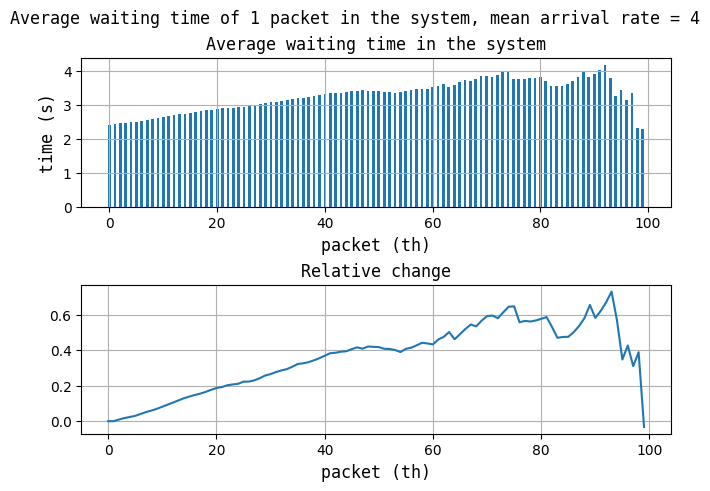

Average waiting time in the system: 3.2073720489118043
Variance of average waiting time in the system: 0.20972559442491473
Variance of relative change: 0.03587498631722215


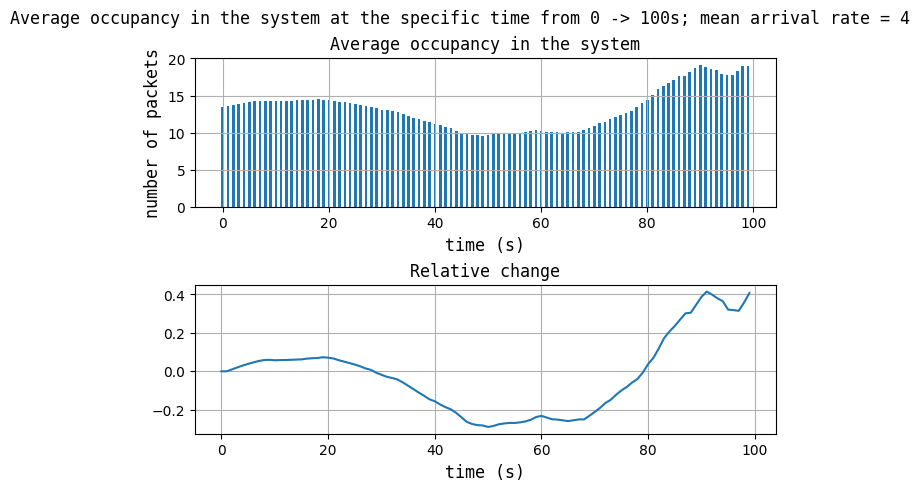

Average Total Occupacy: 12.91819446200531
Variance of average total occupancy: 7.643582082979343
Variance of relative change: 0.040114772811001266


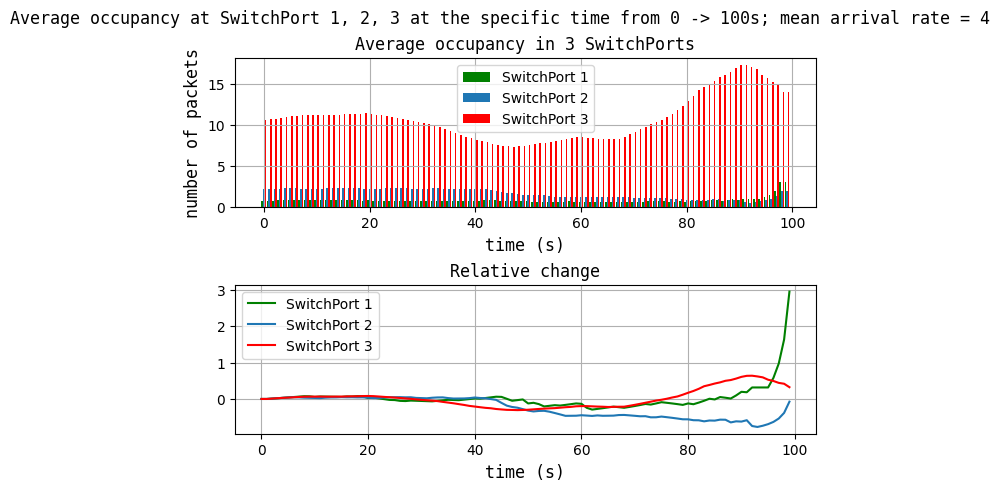

Average occupancy in SwitchPor1: 0.6576052598305727
Average occupancy in SwitchPor2: 2.5712158808933
Average occupancy in SwitchPor3: 9.697865353037766
Variance of average occupancy in SwitchPort 1: 0.13073005907199964
Variance of average occupancy in SwitchPort 2: 0.34776896934945856
Variance of average occupancy in SwitchPort 3: 7.509301195909266
Variance of relative change of SwitchPort 1: 0.1420146438621621
Variance of relative change of SwitchPort 2: 0.07485161931299464
Variance of relative change of SwitchPort 3: 0.06618028659780852


In [11]:
if __name__ == "__main__":
    main()